##Neste notebook irei reestimar os parâmetros ternários para o modelo de Wilson no sistema Acetona-Metanol-Água mas usando como parâmetros iniciais, a_W, não aqueles presentes na tabela 12.5 do Smith Van Ness Abott, mas aqueles que já foram estimados em 3 outros notebooks para os sistemas binários: Acetona-Água, Acetona-Metanol e Metanol-Água. Dessa maneira, irei verificar a influência dessa pré determinação de parâmetros binários ótimos na estimação dos parâmetros ternários ótimos.

In [1]:
# Preparando kernel
import numpy as np
import pandas as pd
!pip3 install pickle5
import pickle5 as pickl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=256394 sha256=e8e94640877c0eb04f6dbb35bb9b483141feb915ab048152c1e839aef84253ae
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [3]:
# Montando o Google drive
from google.colab import drive
drive.mount('/content/drive')
# Para ler/carregar
path = '/content/drive/MyDrive/Operações 3/'
#path = '/content/drive/MyDrive/Classroom/OpUnit3_files/OU3_Python/'
with open(path + 'databank_properties.pickle', 'rb') as handle:
    dados, all_units = pickl.load(handle)
print(dados.shape)
# Incluindo uma pasta do drive (mounted) no path do COLAB
import sys
sys.path.append(path)
# Carregamento das funções úteis
from OU3_funcoes_uteis_v05_2 import *

Mounted at /content/drive
(468, 31)


In [4]:
# Para procurar o 'num' de um determinado componente pelo nome
dados[dados.name.str.contains('water', case = False)]

,num,name,molar_mass,fusion_point,boiling_point,critical_temp,critical_pressure,critical_volume,zc,acentric_factor,...,pvap_a,pvap_b,pvap_c,temp_max_pvap,temp_min_pvap,pvap_h_a,pvap_h_b,pvap_h_c,pvap_h_d,delta_h_vap_bp
466,20,WATER,18.015,273.2,373.2,647.3,217.6,56.0,0.229,0.344,...,18.3036,3816.44,-46.13,441.0,284.0,55.336,-6869.5,-5.115,1.05,9717.0


In [5]:
# Seleção dos componentes presentes no sistema
lista_componentes = [122, 62, 20]
nc = len(lista_componentes)
nc

3

In [6]:
dados[dados['num'].isin(lista_componentes)][['num','name']]

,num,name
145,122,ACETONE
296,62,METHANOL
466,20,WATER


In [7]:
# Verificando os pontos de ebulição de nossos componentes
T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
T_eb_comp = T_eb_comp.tolist()
T_eb_comp

[329.4, 337.8, 373.2]

##Inserindo na célula abaixo os valores de a_W estimados para os sistemas binários anteriormente

In [8]:
# Valores do a_W - Estimados
# acetona = 1
# metanol = 2
# água    = 3
nc = 3
a_W = np.zeros((nc,nc))
# acetona e água
a_W[1-1,3-1] = 2110.10963894
a_W[3-1,1-1] = -352.2639344
# metanol e água
a_W[2-1,3-1] = 1257.02281359
a_W[3-1,2-1] = -398.98898724
# acetona e metanol
a_W[1-1,2-1] = 703.93084504
a_W[2-1,1-1] = -271.24825215
#
a_W

array([[   0.        ,  703.93084504, 2110.10963894],
       [-271.24825215,    0.        , 1257.02281359],
       [-352.2639344 , -398.98898724,    0.        ]])

In [9]:
V_m = f_Vol_molar_db(lista_componentes, dados)
V_m

array([73.51898734, 40.50821745, 18.0511022 ])

In [10]:
z = np.array([0.1,0.2,0.7])

In [11]:
P_eq = 101.33*(760.0/101.325) # mmHg
P_eq

760.0375030841352

In [12]:
def f_calc_T_Pb_nid_Wilson_01_db(z, P_eq, a_W, V_m, lista_componentes, dados):
  ''' Algoritmo de BOL_T descrito na figura 14.3 p.409 do SVNA
  '''
  nc = z.shape[0]
  resp = f_calculo_PbPo_db('T', P_eq, z, lista_componentes, dados)
  T_pb_ideal = resp[0]
  T_pb = T_pb_ideal
  x_eq = z
  y_eq = f_sol_RR_flash_db(z, P_eq, T_pb, lista_componentes, dados)['y_eq']
  K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, a_W, V_m, 
                                       lista_componentes, dados)
  # Eq.14.8 do SVNA
  y_eq_novo = K_comp * x_eq
  phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
  gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
  # Componente de referência
  jj = 2
  # Eq. 14.13 do SVNA
  fator = x_eq*gama_comp/phi_comp
  Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
  razao = Pvap_comp/Pvap_comp[jj]
  somat = fator @ razao
  Pvap_novo = P_eq / somat
  # Eq. 14.15 do SVNA
  T_pb_novo = f_Teq_Antoine_db(Pvap_novo, lista_componentes[jj], dados)[0]
  erro_T = T_pb_novo - T_pb
  # Tolerância para convergência
  epsilon = 1.0e-3
  #
  T_pb = T_pb_novo
  y_eq = y_eq_novo
  k_iter = 1
  n_max_iter = 20
  while ((np.abs(erro_T).mean() > epsilon)&(k_iter < n_max_iter)):
    #print(k_iter, np.abs(erro_T).mean())
    K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, 
                                       a_W, V_m, lista_componentes, dados)
    y_eq_novo = K_comp * x_eq
    phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
    gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
    fator = x_eq*gama_comp/phi_comp
    Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
    T_pb_novo = np.zeros((nc,))
    for j in range(0,nc):
      razao = Pvap_comp/Pvap_comp[j]
      somat = fator @ razao
      Pvap_novo = P_eq / somat
      T_pb_novo[j] = f_Teq_Antoine_db(Pvap_novo, lista_componentes[j], dados)[0]
    erro_T = T_pb_novo[jj] - T_pb
    T_pb = T_pb_novo[jj] # T_pb_novo.mean()
    y_eq = y_eq_novo
    k_iter += 1
  #
  return {'T_pb': T_pb, 'y_eq':y_eq, 'erro_T': np.abs(erro_T)}

In [13]:
sol_T_Pb = f_calc_T_Pb_nid_Wilson_01_db(z, P_eq, a_W, V_m, lista_componentes, dados)
sol_T_Pb

{'T_pb': 340.05930409657776,
 'y_eq': array([0.4361837 , 0.34663128, 0.21720766]),
 'erro_T': 0.0005125367449068108}

In [14]:
caminho = '/content/drive/MyDrive/PFG_Mateus_Ferreira/'
#caminho = '/content/drive/MyDrive/PFG_EQ/PFG_Mateus_Ferreira/'
arquivo_excel = 'Dados_validacao_Bolha_T_Wilson.xlsx'
df = pd.read_excel(caminho+arquivo_excel)
df.head()

,T [K],x1 [mol/mol],x2 [mol/mol],y1 [mol/mol],y2 [mol/mol]
0,345.95,0.0188,0.3778,0.0912,0.6450
1,340.65,0.0253,0.6722,0.0773,0.7869
2,342.35,0.0331,0.5564,0.0953,0.7191
3,337.35,0.0429,0.8710,0.0945,0.8710
4,337.55,0.0449,0.8439,0.1018,0.8496


In [15]:
#Tamanho do Data Frame:
df.shape

(54, 5)

In [16]:
#Trocando o nome das colunas para facilitar:
#
df['x1'] = df.pop('x1\xa0[mol/mol]')
df['x2'] = df.pop('x2\xa0[mol/mol]')
df['y1'] = df.pop('y1\xa0[mol/mol]')
df['y2'] = df.pop('y2\xa0[mol/mol]')  
#
df.head()

,T [K],x1,x2,y1,y2
0,345.95,0.0188,0.3778,0.0912,0.6450
1,340.65,0.0253,0.6722,0.0773,0.7869
2,342.35,0.0331,0.5564,0.0953,0.7191
3,337.35,0.0429,0.8710,0.0945,0.8710
4,337.55,0.0449,0.8439,0.1018,0.8496


In [17]:
#Inserindo as colunas com os valores de x3 e y3
df['x3'] =  1 - (df['x1'] + df['x2'])
df['y3'] =  1 - (df['y1'] + df['y2'])
#
#Reordenando as colunas do Data Frame
df = df[['T [K]','x1', 'x2', 'x3', 'y1', 'y2', 'y3']]
df.head()

,T [K],x1,x2,x3,y1,y2,y3
0,345.95,0.0188,0.3778,0.6034,0.0912,0.6450,0.2638
1,340.65,0.0253,0.6722,0.3025,0.0773,0.7869,0.1358
2,342.35,0.0331,0.5564,0.4105,0.0953,0.7191,0.1856
3,337.35,0.0429,0.8710,0.0861,0.0945,0.8710,0.0345
4,337.55,0.0449,0.8439,0.1112,0.1018,0.8496,0.0486


In [19]:
a_W

array([[   0.        ,  703.93084504, 2110.10963894],
       [-271.24825215,    0.        , 1257.02281359],
       [-352.2639344 , -398.98898724,    0.        ]])

In [18]:
par = np.array([2110.10963894, -352.2639344, 1257.02281359, -398.98898724, 703.93084504, -271.24825215]) #Parâmetros binários estimados
#par = np.array([350.0, 1448.01, 107.38, 469.55, -161.88, 583.11])
par

array([2110.10963894, -352.2639344 , 1257.02281359, -398.98898724,
        703.93084504, -271.24825215])

In [ ]:
df.loc[0,'T [K]']

345.95

In [ ]:
def f_res_par(par, P_eq, V_m, lista_componentes, dados, df):
  '''
    Entradas:
      df: dataframe com os dados experimentais para a estimação
    Saidas:

  '''
  nc = 3
  a_W = np.zeros((nc,nc))
  #
  a_W[1-1,3-1] = par[0]
  a_W[3-1,1-1] = par[1]
  # metanol e água
  a_W[2-1,3-1] = par[2]
  a_W[3-1,2-1] = par[3]
  # acetona e metanol
  a_W[1-1,2-1] = par[4]
  a_W[2-1,1-1] = par[5]
  #
  composicoes = df[['x1', 'x2', 'x3']]
  x1 = composicoes['x1'].tolist()
  x2 = composicoes['x2'].tolist()
  x3 = composicoes['x3'].tolist()
  z = np.array(list(zip(x1, x2, x3)))
  #
  n_exp = df.shape[0]
  res_T = np.zeros((n_exp,))
  res_y1 = np.zeros((n_exp,))
  res_y2 = np.zeros((n_exp,))
  res_y3 = np.zeros((n_exp,))
  for k in range(0,n_exp):
    #print(k)
    sol_T_Pb = f_calc_T_Pb_nid_Wilson_01_db(z[k], P_eq, a_W, V_m, lista_componentes, dados)
    res_T[k] = df.loc[k,'T [K]'] - sol_T_Pb['T_pb']
    res_y1[k] = df.loc[k,'y1'] - sol_T_Pb['y_eq'][0]
    res_y2[k] = df.loc[k,'y2'] - sol_T_Pb['y_eq'][1]
    res_y3[k] = df.loc[k,'y3'] - sol_T_Pb['y_eq'][2]
  #
  #res = np.zeros((n_exp,))
  res = np.abs(res_T) + np.abs(res_y1) + np.abs(res_y2) + np.abs(res_y3)
  return (res)

In [ ]:
%%capture
res = f_res_par(par, P_eq, V_m, lista_componentes, dados, df)

In [ ]:
res

array([1.78191405, 0.6384398 , 1.53908382, 0.33135977, 0.34176544,
       1.7442057 , 2.22070536, 1.42576377, 0.68308868, 0.29250748,
       1.59692805, 2.17810572, 1.97046282, 0.48809992, 0.21288327,
       1.15053138, 1.54062994, 1.74282569, 0.11476443, 1.51448063,
       1.25092951, 1.31094757, 1.50941468, 0.24001812, 0.83929519,
       0.76714162, 1.2887196 , 0.58798369, 0.91607583, 0.94101394,
       1.51203589, 1.10855817, 0.12692619, 0.22294461, 0.0588005 ,
       1.22696383, 0.68950736, 0.67861972, 0.99134499, 0.53244474,
       0.36005814, 0.33922611, 0.23631163, 0.11100534, 0.25156138,
       0.07707735, 0.14556589, 0.11867054, 0.22827824, 0.20309216,
       0.11948867, 0.04520084, 0.44565398, 0.12557933])

In [ ]:
#Isso foi definido no notebook anterior para fazer uma reestimação dos parâmetros ótimos usando os primeiros parâmetros ótimos obtidos.
#par0= np.array([2552.62415561, -542.90749412, 714.24545824, -147.86284985, 291.73645055, 266.52211273])

In [ ]:
%%capture
from scipy.optimize import least_squares
# resp = least_squares(f_res_par, par, args=(P_eq, V_m, lista_componentes, dados, df))
resp = least_squares(f_res_par, par, method = 'lm',
                     args=(P_eq, V_m, lista_componentes, dados, df))

In [ ]:
resp

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.013e-01  3.480e-01 ...  4.523e-01  1.435e-01]
           x: [ 2.268e+03 -3.387e+02  5.426e+03 -8.281e+02  7.737e+02
               -3.024e+02]
        cost: 2.431125332916364
         jac: [[-7.265e-04 -6.158e-04 ... -2.359e-03 -2.721e-03]
               [-2.050e-04 -2.162e-04 ... -2.458e-03 -2.389e-03]
               ...
               [-3.270e-04 -1.957e-03 ... -1.257e-03 -2.198e-03]
               [ 2.610e-04  1.639e-03 ...  9.379e-04  1.654e-03]]
        grad: [-1.297e-05 -1.902e-04 -3.322e-06 -3.507e-04 -7.465e-05
               -1.567e-04]
  optimality: 0.00035069854058073933
 active_mask: [0 0 0 0 0 0]
        nfev: 130
        njev: None

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.013e-01  3.480e-01 ...  4.523e-01  1.435e-01]
           x: [ 2.268e+03 -3.387e+02  5.426e+03 -8.281e+02  7.737e+02
               -3.024e+02]
        cost: 2.431125332916364
         jac: [[-7.265e-04 -6.158e-04 ... -2.359e-03 -2.721e-03]
               [-2.050e-04 -2.162e-04 ... -2.458e-03 -2.389e-03]
               ...
               [-3.270e-04 -1.957e-03 ... -1.257e-03 -2.198e-03]
               [ 2.610e-04  1.639e-03 ...  9.379e-04  1.654e-03]]
        grad: [-1.297e-05 -1.902e-04 -3.322e-06 -3.507e-04 -7.465e-05
               -1.567e-04]
  optimality: 0.00035069854058073933
 active_mask: [0 0 0 0 0 0]
        nfev: 130
        njev: None

In [ ]:
#Parâmetros não otimizados
par

array([2110.10963894, -352.2639344 , 1257.02281359, -398.98898724,
        703.93084504, -271.24825215])

In [ ]:
#Parâmetros ótimos
par_opt = resp.x
par_opt

array([2267.89392205, -338.68300608, 5425.52213547, -828.07796492,
        773.69265775, -302.3637767 ])

###Poucos parâmetros mudaram muito o valor e nenhum deles mudou de sinal. Além disso, o processo de estimação demorou menos que aquele usando como parâmetros iniciais os da tabela 12.5 do SVNA.

In [ ]:
#Calculando os resíduos (que devem ser os menores possíveis) utilizando os parâmetros ótimos 
%%capture
res_opt = f_res_par(par_opt, P_eq, V_m, lista_componentes, dados, df)

In [ ]:
#Resíduos usando os parâmetros ótimos
res_opt

array([0.20133442, 0.34800315, 0.20376994, 0.16683443, 0.09965971,
       0.52335226, 0.90049075, 0.09816938, 0.18662312, 0.22343611,
       0.15956647, 0.05721643, 0.2673862 , 0.3050025 , 0.02606109,
       0.4896063 , 0.17021493, 0.20545175, 0.12537625, 0.14965201,
       0.17196248, 0.17845933, 0.13411156, 0.11763252, 0.14093926,
       0.31762252, 0.04164038, 0.16224477, 0.09177725, 0.60106037,
       0.66117613, 0.21253089, 0.04175988, 0.45893232, 0.09833185,
       0.60951273, 0.08840174, 0.07306   , 0.5198685 , 0.4744715 ,
       0.08268931, 0.3029931 , 0.13351844, 0.10559297, 0.14130337,
       0.20485775, 0.16237445, 0.28350304, 0.26635753, 0.27223192,
       0.1830838 , 0.05481123, 0.45231801, 0.14350374])

In [ ]:
#Resíduos usando os parâmetros não ótimos, a fim de compara ambos
res

array([1.78191405, 0.6384398 , 1.53908382, 0.33135977, 0.34176544,
       1.7442057 , 2.22070536, 1.42576377, 0.68308868, 0.29250748,
       1.59692805, 2.17810572, 1.97046282, 0.48809992, 0.21288327,
       1.15053138, 1.54062994, 1.74282569, 0.11476443, 1.51448063,
       1.25092951, 1.31094757, 1.50941468, 0.24001812, 0.83929519,
       0.76714162, 1.2887196 , 0.58798369, 0.91607583, 0.94101394,
       1.51203589, 1.10855817, 0.12692619, 0.22294461, 0.0588005 ,
       1.22696383, 0.68950736, 0.67861972, 0.99134499, 0.53244474,
       0.36005814, 0.33922611, 0.23631163, 0.11100534, 0.25156138,
       0.07707735, 0.14556589, 0.11867054, 0.22827824, 0.20309216,
       0.11948867, 0.04520084, 0.44565398, 0.12557933])

##Criando uma função que lê uma lista de listas de composições de misturas ternárias e calcula o bolha T para elas:

In [ ]:
def calcular_ponto_bolha_3_componentes(composicoes, P_eq, a_W, V_m, lista_componentes, dados):
    '''função que calcula a temperatura do ponto de bolha e a composição da fase vapor para uma mistura de componentes e
    armazena os valores em um Data Frame chamado df_resultados.
    z é a lista (ou lista de listas) da composição da fase líquida e P_eq é a pressão de equilíbrio do sistema'''
    resultados = []
    for composicao in composicoes:
        # Chame a função que realiza o cálculo da temperatura do ponto de bolha
        # e da composição da fase vapor com base na composição da mistura e na pressão do sistema
        T_pb_Wilson             = f_calc_T_Pb_nid_Wilson_01_db(composicao, P_eq, a_W, V_m, lista_componentes, dados)['T_pb']
        y1_Wilson               = f_calc_T_Pb_nid_Wilson_01_db(composicao, P_eq, a_W, V_m, lista_componentes, dados)['y_eq'][0]
        y2_Wilson               = f_calc_T_Pb_nid_Wilson_01_db(composicao, P_eq, a_W, V_m, lista_componentes, dados)['y_eq'][1]
        y3_Wilson               = f_calc_T_Pb_nid_Wilson_01_db(composicao, P_eq, a_W, V_m, lista_componentes, dados)['y_eq'][2]
        
        # Adicione os resultados em uma lista como tuplas
        resultados.append((composicao, T_pb_Wilson, y1_Wilson, y2_Wilson, y3_Wilson))
    
    # Criando um DataFrame a partir da lista de resultados
    df_resultados = pd.DataFrame(resultados, columns=["Composição", "T_pb_Wilson", "y1_Wilson", "y2_Wilson", "y3_Wilson"])
    
    return df_resultados

In [ ]:
#Transformando os dados de entrada do que estão no Data Frame em uma lista de listas onde cada lista interna contém os valores de fração molar
# de cada componente
x1 = df['x1'].tolist()
x2 = df['x2'].tolist()
x3 = df['x3'].tolist()
lista_composicoes = np.array(list(zip(x1, x2, x3)))
lista_composicoes[0:5]

array([[0.0188, 0.3778, 0.6034],
       [0.0253, 0.6722, 0.3025],
       [0.0331, 0.5564, 0.4105],
       [0.0429, 0.871 , 0.0861],
       [0.0449, 0.8439, 0.1112]])

In [ ]:
#Criando o Data Frame com os resultados calculados por Wilson:
#O comando CAPTURE é para suprimir a saída da célula para poupar espaço, mas ele também impede a célula de exibir uma mensagem de erro 
%%capture
resultado = calcular_ponto_bolha_3_componentes(lista_composicoes, P_eq, a_W, V_m, lista_componentes, dados)

In [ ]:
resultado

,Composição,T_pb_Wilson,y1_Wilson,y2_Wilson,y3_Wilson
0,"[0.0188, 0.3778, 0.6033999999999999]",344.221202,0.095732,0.667029,0.237246
1,"[0.0253, 0.6722, 0.3025]",340.015335,0.078523,0.787582,0.133930
2,"[0.0331, 0.5564, 0.4105]",340.850623,0.115157,0.716851,0.168000
3,"[0.0429, 0.871, 0.08609999999999995]",337.051812,0.101699,0.854428,0.043900
4,"[0.0449, 0.8439, 0.11119999999999997]",337.234571,0.108214,0.836448,0.055370
5,"[0.0628, 0.3042, 0.633]",341.538555,0.279119,0.502382,0.218540
6,"[0.0639, 0.1166, 0.8195]",343.775341,0.433133,0.292038,0.274859
7,"[0.0724, 0.4985, 0.42910000000000004]",339.242849,0.226917,0.610634,0.162470
8,"[0.0757, 0.715, 0.20930000000000004]",337.169834,0.184467,0.722543,0.093002
9,"[0.084, 0.0401, 0.8759]",343.080094,0.607453,0.113266,0.279305


##Agora tendo os valores calculados por Wilson e aqueles experimentais presentes no conjunto de dados faz-se um comparativo entre ambos

#Fazendo uma análise gráfica dos resultados por uma reta de referência em relação a cada uma das variáveis de reposta: $T_{pb}$, $y_1, y_2$ e $y_3$


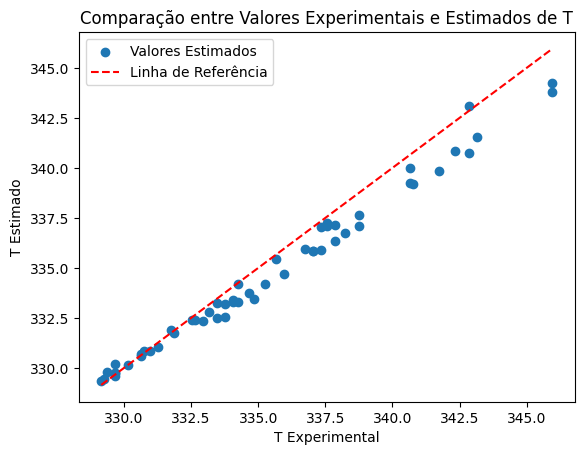

In [ ]:
import matplotlib.pyplot as plt

# Criando um gráfico de dispersão com linha de regressão para T

plt.scatter(df['T [K]'], resultado['T_pb_Wilson'], label='Valores Estimados')
plt.plot([df['T [K]'].min(), df['T [K]'].max()], [df['T [K]'].min(), df['T [K]'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('T Experimental')
plt.ylabel('T Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de T')
plt.legend()
plt.show()

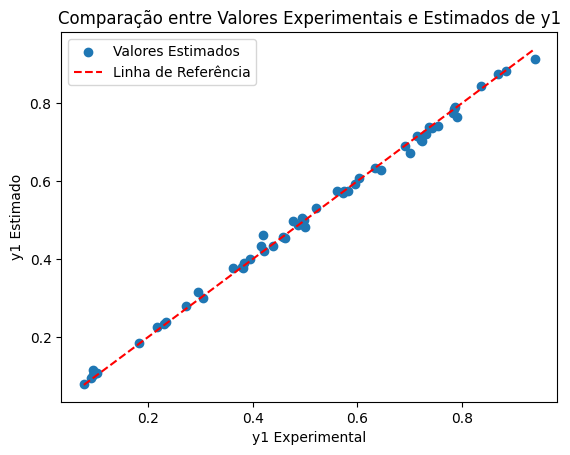

In [ ]:
# Criando um gráfico de dispersão com linha de regressão para y1

plt.scatter(df['y1'], resultado['y1_Wilson'], label='Valores Estimados')
plt.plot([df['y1'].min(), df['y1'].max()], [df['y1'].min(), df['y1'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y1 Experimental')
plt.ylabel('y1 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y1')
plt.legend()
plt.show()

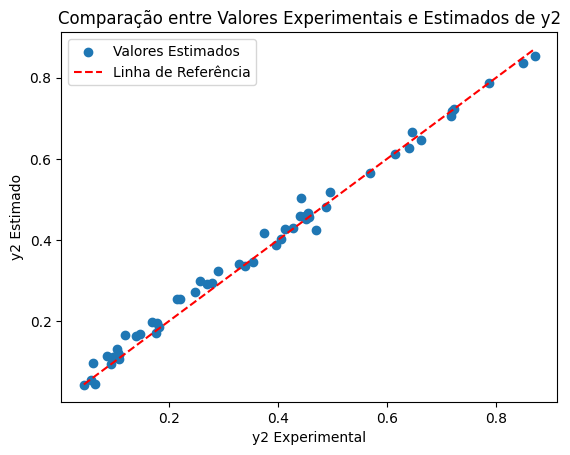

In [ ]:
# Criando um gráfico de dispersão com linha de regressão para y2

plt.scatter(df['y2'], resultado['y2_Wilson'], label='Valores Estimados')
plt.plot([df['y2'].min(), df['y2'].max()], [df['y2'].min(), df['y2'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y2 Experimental')
plt.ylabel('y2 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y2')
plt.legend()
plt.show()

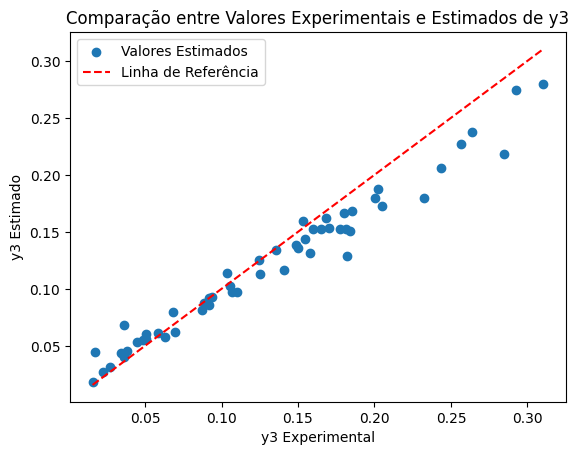

In [ ]:
# Criando um gráfico de dispersão com linha de regressão para y3

plt.scatter(df['y3'], resultado['y3_Wilson'], label='Valores Estimados')
plt.plot([df['y3'].min(), df['y3'].max()], [df['y3'].min(), df['y3'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y3 Experimental')
plt.ylabel('y3 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y3')
plt.legend()
plt.show()

In [ ]:
# Importando o pacote com as figuras de mérito para avaliar o modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Calculando o erro médio absoluto (MAE)
mae_T = mean_absolute_error(df['T [K]'], resultado['T_pb_Wilson'])
mae_y1 = mean_absolute_error(df['y1'], resultado['y1_Wilson'])
mae_y2 = mean_absolute_error(df['y2'], resultado['y2_Wilson'])
mae_y3 = mean_absolute_error(df['y3'], resultado['y3_Wilson'])

# Calculando o erro quadrático médio (MSE)
mse_T = mean_squared_error(df['T [K]'], resultado['T_pb_Wilson'])
mse_y1 = mean_squared_error(df['y1'], resultado['y1_Wilson'])
mse_y2 = mean_squared_error(df['y2'], resultado['y2_Wilson'])
mse_y3 = mean_squared_error(df['y3'], resultado['y3_Wilson'])

# Calculando a raiz do erro quadrático médio (RMSE)
rmse_T  = np.sqrt(mse_T)
rmse_y1 = np.sqrt(mse_y1)
rmse_y2 = np.sqrt(mse_y2)
rmse_y3 = np.sqrt(mse_y3)

# Calculando o coeficiente de determinação (R²)
r2_T  = r2_score(df['T [K]'], resultado['T_pb_Wilson'])
r2_y1 = r2_score(df['y1'], resultado['y1_Wilson'])
r2_y2 = r2_score(df['y2'], resultado['y2_Wilson'])
r2_y3 = r2_score(df['y3'], resultado['y3_Wilson'])

In [ ]:
#Imprimindo os resultados:
print("Erro Médio Absoluto (MAE) para T: ", mae_T)
print("Erro Médio Absoluto (MAE) para y1: ", mae_y1)
print("Erro Médio Absoluto (MAE) para y2: ", mae_y2)
print("Erro Médio Absoluto (MAE) para y3: ", mae_y3)
print("Erro Quadrático Médio (MSE) para T: ", mse_T)
print("Erro Quadrático Médio (MSE) para y1: ", mse_y1)
print("Erro Quadrático Médio (MSE) para y2: ", mse_y2)
print("Erro Quadrático Médio (MSE) para y3: ", mse_y3)
print("Raiz do Erro Quadrático Médio (RMSE) para T: ", rmse_T)
print("Raiz do Erro Quadrático Médio (RMSE) para y1: ", rmse_y1)
print("Raiz do Erro Quadrático Médio (RMSE) para y2: ", rmse_y2)
print("Raiz do Erro Quadrático Médio (RMSE) para y3: ", rmse_y3)
print("Coeficiente de Determinação (R²) para T: ", r2_T)
print("Coeficiente de Determinação (R²) para y1: ", r2_y1)
print("Coeficiente de Determinação (R²) para y2: ", r2_y2)
print("Coeficiente de Determinação (R²) para y3: ", r2_y3)

Erro Médio Absoluto (MAE) para T:  0.7570648991093747
Erro Médio Absoluto (MAE) para y1:  0.009017916821989158
Erro Médio Absoluto (MAE) para y2:  0.01659365279019961
Erro Médio Absoluto (MAE) para y3:  0.015749477559560476
Erro Quadrático Médio (MSE) para T:  0.9572493579402982
Erro Quadrático Médio (MSE) para y1:  0.00015631689980606263
Erro Quadrático Médio (MSE) para y2:  0.0004756169053390463
Erro Quadrático Médio (MSE) para y3:  0.000452537074515546
Raiz do Erro Quadrático Médio (RMSE) para T:  0.9783912090469222
Raiz do Erro Quadrático Médio (RMSE) para y1:  0.012502675705866429
Raiz do Erro Quadrático Médio (RMSE) para y2:  0.021808642904569884
Raiz do Erro Quadrático Médio (RMSE) para y3:  0.02127291880573858
Coeficiente de Determinação (R²) para T:  0.9522732897156236
Coeficiente de Determinação (R²) para y1:  0.9970202153925645
Coeficiente de Determinação (R²) para y2:  0.9906978334199212
Coeficiente de Determinação (R²) para y3:  0.9228471863762555
